# Prelim

## Imports

*  "C1" = Cluster 1
*  "CP" = Cluster Prime Parameter
*  "FGM" = Flux Gate Magnetometer
*  "5VPS" = 5 vectors/second resolution
*  Skeleton table: https://spdf.gsfc.nasa.gov/pub/software/cdawlib/0SKELTABLES/c1_cp_fgm_5vps_00000000_v01.skt

In [72]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import spacepy
from spacepy.coordinates import Coords
from spacepy.time import Ticktock
from spacepy import pycdf

from time import strftime, localtime
from datetime import datetime
import pandas as pd
import bisect

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [71]:
R_E = 6370     # Cluster takes 1 earth radius to be 6370 km
R_E = 6378.137 # Spacepy takes 1 earth radius to be 6370 km 

### User friendly cdf functions

In [3]:
cdf = pycdf.CDF('../Data/2020_Feb_Cluster/C1_CP_FGM_5VPS__20200101_000000_20200102_000000_V210330.cdf')

In [4]:
print(cdf)

B_mag__C1_CP_FGM_5VPS: CDF_FLOAT [432000]
B_vec_xyz_gse__C1_CP_FGM_5VPS: CDF_FLOAT [432000, 3]
B_vec_xyz_gse__C1_CP_FGM_5VPS_LABEL_1: CDF_CHAR*2 [3] NRV
B_vec_xyz_gse__C1_CP_FGM_5VPS_REPRESENTATION_1: CDF_CHAR*1 [3] NRV
half_interval__C1_CP_FGM_5VPS: CDF_FLOAT [432000]
range__C1_CP_FGM_5VPS: CDF_INT4 [432000]
sc_pos_xyz_gse__C1_CP_FGM_5VPS: CDF_FLOAT [432000, 3]
sc_pos_xyz_gse__C1_CP_FGM_5VPS_LABEL_1: CDF_CHAR*1 [3] NRV
sc_pos_xyz_gse__C1_CP_FGM_5VPS_REPRESENTATION_1: CDF_CHAR*1 [3] NRV
time_tags__C1_CP_FGM_5VPS: CDF_EPOCH [432000]
tm__C1_CP_FGM_5VPS: CDF_INT4 [432000]


In [5]:
print(cdf.raw_var('time_tags__C1_CP_FGM_5VPS')[...].astype(int))

[-2147483648 -2147483648 -2147483648 ... -2147483648 -2147483648
 -2147483648]


C:\Users\joels\AppData\Local\Temp\ipykernel_6416\602135660.py:1: RuntimeWarning: invalid value encountered in cast
  print(cdf.raw_var('time_tags__C1_CP_FGM_5VPS')[...].astype(int))


In [6]:
print(cdf['B_vec_xyz_gse__C1_CP_FGM_5VPS'][...])

[[ -7.552  12.531  -3.687]
 [ -7.469  12.542  -3.571]
 [ -7.452  12.391  -3.569]
 ...
 [-89.251   8.319 141.047]
 [-89.231   8.257 141.018]
 [-89.237   8.462 141.022]]


## Definitions

### Extracting LUNA Data

#### File Handling

In [9]:
def read_processed_cdf(cdf_file_path, segment_column='epoch', delta=200.0):
    """
    Reads all data from a CDF file, stores it in a pandas DataFrame, and segments 
    the data based on time gaps in the specified column.

    Parameters
    ----------
    cdf_file_path : str
        The path to the processed CDF file.
    segment_column : str, optional
        The name of the column with time values for segmenting data.
    delta : float, optional
        The time gap threshold for segmenting data.

    Returns
    -------
    pandas.DataFrame :
        A DataFrame containing all data from the CDF file, with each variable as a column,
        including a 'segment' column for plotting purposes.
    """
    data_dict = {}

    with pycdf.CDF(cdf_file_path) as cdf:
        for var in cdf:
            data_dict[var] = cdf[var][...]

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data_dict)
    
    # Call segment_dataframe to add the 'segment' column
    segment_dataframe(df, column=segment_column, delta=delta)
    
    return df


In [7]:
def save_data_frame(df, output_cdf_file):
    """
    Saves the dataframe to a cdf file.

    Parameters
    ----------
    df : pandas.DataFrame 
        Input DataFrame containing data for every epoch time.
    output_cdf_file : str
        The path where to save the processed CDF file.

    Returns
    -------
        None : the procedure just saves data to the file.
    """
    # Check if the CDF file already exists
    cdf_file_exists = os.path.exists(output_cdf_file)

    with pycdf.CDF(output_cdf_file, create=not cdf_file_exists) as cdf_out:
        cdf_out.readonly(False)
            
        # Write each column in the DataFrame to the CDF file
        for column in df.columns:
            if column not in cdf_out:
                # Create new variable in the CDF if it doesn’t exist
                cdf_out[column] = df[column].values

                # Add units attribute to distance columns
                if 'r_' in column:
                    cdf_out[column].attrs['units'] = 'Re'
            else:
                # If the column already exists, extend the existing data
                existing_data = cdf_out[column][...]
                new_data = np.concatenate((existing_data, df[column].values))
                cdf_out[column] = new_data  # Update the CDF column with combined data

#### Processing Data

In [8]:
def resample_cdf_data(df, time_col='epoch', sample_interval='min'):
    """
    Resamples CDF-based epoch time data to 1-minute intervals, calculating the mean of each bin, and removing rows 
    with NaN values, where each row is for the time mid-point.

    Parameters
    ----------
    df : pandas.DataFrame 
        Input DataFrame containing time data in CDF epoch format and other data columns.
    time_col : str, optional 
        Name of the column in `df` with CDF epoch time values to be converted.
        Default value is 'epoch'.
    sample_interval : str, optional 
        The size of the bins overwhich the data is sampled/averaged.
        Default value is 'min'.

    Returns
    -------
    pandas.DataFrame :
        A DataFrame resampled to 1-minute bins, with mean values calculated for each bin.
    """
    # Convert 'epoch' to datetime format for resampling
    df['time'] = Ticktock(df[time_col], 'CDF').UTC

    # Set 'time' as the index for time-based grouping
    df.set_index('time', inplace=True)

    # Resample to 1-minute bins and calculate the mean
    df_resampled = df.resample(sample_interval).mean()

    # Reset index to make 'time' a column again
    df_resampled.reset_index(inplace=True)

    # Drop 'segment' and 'time' columns before saving
    df_resampled.drop(columns=['segment', 'time'], inplace=True, errors='ignore')

    # Removes all rows where any data is NaN (in this case, no data was sampled)

    return df_resampled.dropna()

In [10]:
def segment_dataframe(df, column='epoch', delta=200.0):
    """
    Adds a 'segment' column to the DataFrame based on time gaps exceeding a threshold, (for plotting purposes).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be segmented.
    column : str, optional
        The name of the column with time values.
    delta : float, optional
        The time gap threshold for segmenting data.

    Returns
    -------
        None : the procedure modifies the input DataFrame in place.
    """

    # Calculate the time differences between consecutive rows
    time_diffs = df[column].diff()

    # Create the 'segment' column in a single operation
    df.insert(0, 'segment', (time_diffs > delta).cumsum())

#### Plotting Data

In [105]:
def plot_orbit_components(df, coords='GSE'):
    """
    Procedure to plot the cartesian coordinate components of the position vector of the satellite over time.
    Can specify the coordinate frame.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be plotted.
    coords : str, optional
        The coordinate system in which to plot the data (from Spacepy).
        Default is the GSE coordinate frame.
    
    Returns
    -------
        None : procedure just plots a figure.
    """
    key = f'r_x_{coords}'
    if key not in df.keys():
        print("Coordinate system not found in data.")
        return
    
    fig, axs = plt.subplots(4,  # 4 plots
                        figsize=(12,12), 
                        sharex=True, # share same x-range
                        sharey=False, # don't share same y-range
                        gridspec_kw={'hspace': 0})

    for _, segment in df.groupby('segment'):
        time = Ticktock(segment['epoch'], 'CDF').UTC
        
        axs[0].plot(time, segment[f'r_x_{coords}'], c='b', lw=0.5)
        axs[1].plot(time, segment[f'r_y_{coords}'], c='b', lw=0.5)
        axs[2].plot(time, segment[f'r_z_{coords}'], c='b', lw=0.5)
        axs[3].plot(time, segment['r_mag'], c='r', lw=0.5)

        
    start_date_str = str(Ticktock(df['epoch'].iloc[0], 'CDF').ISO)[2:12]
    end_date_str = str(Ticktock(df['epoch'].iloc[-1], 'CDF').ISO)[2:12]
    
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str} in {coords}', fontsize=18)
    
    # Add labels
    plt.xlabel(r'time', fontsize=16)

    # Format the x-axis to display full dates and times with more detail
    # "Hour:Minute:Second // Year-Month-Day"
    date_format = mdates.DateFormatter('%H:%M:%S\n%Y-%m-%d')
    axs[2].xaxis.set_major_formatter(date_format)

    axs[0].set_ylabel(r'$r_x$ [$R_E$]', fontsize=16)
    axs[1].set_ylabel(r'$r_y$ [$R_E$]', fontsize=16)
    axs[2].set_ylabel(r'$r_z$ [$R_E$]', fontsize=16)
    axs[3].set_ylabel(r'$r$ [$R_E$]', fontsize=16)
    
    plt.tight_layout();

    #plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

In [112]:
def plot_orbit(df,x_axis='r_x',y_axis='r_y',coords='GSE'):
    """
    Procedure to plot the orbit of the satellite in the frame of orbit.
    Can specify the coordinate frame.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing data to be plotted.
    x_axis : str, optional
        The coordinate to be plotted along the x-axis of the figure.
        Default is the 'r_x' component.
    y_axis : str, optional
        The coordinate to be plotted along the y-axis of the figure.
        Default is the 'r_y' component.
    coords : str, optional
        The coordinate system in which to plot the data (from Spacepy).
        Default is the GSE coordinate frame.
    
    Returns
    -------
        None : procedure just plots a figure.
    """
    key = f'{x_axis}_{coords}'
    if key not in df.keys():
        print("Coordinate system not computed")
        return
    
    fig, ax = plt.subplots(figsize=(8,6))

    plt.grid(linestyle='--', lw=0.5)
    
    x_label = x_axis + '_' + coords
    y_label = y_axis + '_' + coords
    
    x0 = df[x_label].iloc[0]
    y0 = df[y_label].iloc[0]

    # Add small cross at the start point
    ax.scatter(x0, y0, color='orange', marker='x', s=100)

    # Add Earth
    plt.scatter(0, 0, color='blue', marker='o', s=600)

    for _, segment in df.groupby('segment'):
        ax.plot(segment[x_label], segment[y_label], c='b', lw=0.5)

    # Add arrows to indicate direction
    for i in np.linspace(50, len(df[x_label]) - 2, 20):
        i=int(i)
        xi  = df[x_label].iloc[i]
        yi  = df[y_label].iloc[i]
        xi1 = df[x_label].iloc[i+1]
        yi1 = df[y_label].iloc[i+1]

        ax.arrow(xi, yi, xi1 - xi, yi1 - yi,
             head_width=.3, head_length=.4, fc='red', ec='red')

    start_date_str = str(Ticktock(df['epoch'].iloc[0], 'CDF').ISO)[2:12]
    end_date_str = str(Ticktock(df['epoch'].iloc[-1], 'CDF').ISO)[2:12]
    
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str} in {coords}', fontsize=18)
    
    # Add labels
    plt.xlabel(f'${x_axis}$ [$R_E$] ({coords})', fontsize=16)
    if x_axis == 'r_x' or x_axis == 'r_y':
        plt.gca().invert_xaxis()
    
    plt.ylabel(f'${y_axis}$ [$R_E$] ({coords})', fontsize=16)
    if y_axis == 'r_x' or y_axis == 'r_y':
        plt.gca().invert_yaxis()
        
    plt.tight_layout();

    #plt.savefig(f'{data_name} data on {data_date}.png',bbox_inches='tight')

In [107]:
def plot_heat_map(df,x_axis='r_x',y_axis='r_y',coords='GSE',z_limits=None,bin_size=1):
    """
    Procedure to plot a heat map of the orbit of the satellite in a 2D plane, (x-y).
    Arguments can be adjusted for the pixel size and whether to constrain when close to z=0 or not.

    Parameters
    ----------
    xs : pandas.Series
        The satellite's orbit coordinates plotted on the x-axis.
    ys : pandas.Series
        The satellite's orbit coordinates plotted on the y-axis.
    zs : pandas.Series
        The satellite's orbit coordinates not plotted but counted through for the density profile.
    z_limits : tuples of 2 values, optional 
        Lower and upper limit for the values for the satellite in the z-plane.
        By default is None, (takes all values in z-plane).
    bin-size : int, optional
        Size of the pixels/bins for the heat map.
        By default is 1 (RE).
    weight : Boolean, optional
        Whether to weigh the histogram to display the legend in number of data points (default/False),
        or to weigh and display in minutes (True).

    Returns
    -------
        None : procedure just plots a figure.
    """
    key = f'{x_axis}_{coords}'
    if key not in df.keys():
        print("Coordinate system not computed")
        return
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    x_label = x_axis + '_' + coords
    y_label = y_axis + '_' + coords
    
    labels=['r_x','r_y','r_z']
    try:
        labels.remove(x_axis)
    except NameError:
        print("Invalid choice for x-axis")
    else:
        try:
            labels.remove(y_axis)
        except NameError:
            print("Invalid choice for y-axis")
    finally:
        z_label = labels[0] + '_' + coords
    
    # Calculate the number of bins based on the range of data and the bin size
    x_min, x_max = np.floor(df[x_label].min()), np.ceil(df[x_label].max())
    y_min, y_max = np.floor(df[y_label].min()), np.ceil(df[y_label].max())
    
    # Create bins starting from 0, with bin edges aligned to (0, 0)
    x_bins = np.arange(x_min, x_max + bin_size, bin_size) 
    y_bins = np.arange(y_min, y_max + bin_size, bin_size)

    # If no limits are passed in for z, use full data range
    if z_limits is None:
        z_min, z_max = np.floor(df[z_label].min()), np.ceil(df[z_label].max())
    else:
        z_min, z_max = z_limits[0], z_limits[1]
    
    # Masking data within z range
    mask = (df[z_label] >= z_min) & (df[z_label] <= z_max)

    # Create weights to display color bar
    c_label = 'Number of Points'
    weights = np.ones_like(df[x_label][mask])
    
    # Create the 2D histogram (heatmap)
    plt.hist2d(df[x_label][mask], df[y_label][mask], 
               bins=[x_bins, y_bins], weights=weights, cmap='hot')
    plt.colorbar(label=c_label)
    
    # Add Earth
    plt.scatter(0, 0, color='blue', marker='o', s=600)
  
    # Set the x and y ticks to every 1 unit
    plt.xticks(np.arange(x_min, x_max + 1, 1))
    plt.yticks(np.arange(y_min, y_max + 1, 1))
    
    start_date_str = str(Ticktock(df['epoch'].iloc[0], 'CDF').ISO)[2:12]
    end_date_str = str(Ticktock(df['epoch'].iloc[-1], 'CDF').ISO)[2:12]
    
    fig.suptitle(f'Orbit data from {start_date_str} to {end_date_str} in {coords}\n where {z_min}$R_E$ $\\leq${z_label[2]}$\\leq${z_max} $R_E$', fontsize=18)

    # Add labels
    plt.xlabel(f'${x_axis}$ [$R_E$] ({coords})', fontsize=16)
    if x_axis == 'r_x' or x_axis == 'r_y':
        plt.gca().invert_xaxis()
    
    plt.ylabel(f'${y_axis}$ [$R_E$] ({coords})', fontsize=16)
    if y_axis == 'r_x' or y_axis == 'r_y':
        plt.gca().invert_yaxis()

## Extract Data

In [15]:
# Output CDF file path
processed_cdf_file = 'Processed_Data_2020_Jan_Feb.cdf'

In [16]:
# Reads the processed CDF file and extract the data into a pandas DataFrame
df_fgm = read_processed_cdf(processed_cdf_file, segment_column='epoch', delta=200.0)

In [17]:
df_fgm

,segment,epoch,r_mag,r_x_GSE,r_y_GSE,r_z_GSE,r_x_GSM,r_y_GSM,r_z_GSM
0,0,63745056000100,17.006729,8.579997,13.743809,5.169158,8.579997,12.038954,8.406906
1,0,63745056000300,17.006721,8.580013,13.743778,5.169189,8.580013,12.038916,8.406929
2,0,63745056000500,17.006723,8.580013,13.743762,5.169237,8.580013,12.038889,8.406971
3,0,63745056000700,17.006721,8.580013,13.743747,5.169268,8.580013,12.038866,8.406997
4,0,63745056000900,17.006710,8.580029,13.743714,5.169299,8.580029,12.038827,8.407019
...,...,...,...,...,...,...,...,...,...
21780888,346,63749764790500,16.127077,13.667689,-1.064104,8.493797,13.667689,-2.850198,8.071758
21780889,346,63749764790700,16.127069,13.667659,-1.064119,8.493828,13.667659,-2.850220,8.071785
21780890,346,63749764790900,16.127052,13.667627,-1.064135,8.493843,13.667627,-2.850238,8.071796
21780891,346,63749764791100,16.127031,13.667581,-1.064151,8.493876,13.667581,-2.850260,8.071825


In [19]:
df_fgm_1_min = resample_cdf_data(df_fgm, time_col='epoch')

In [18]:
cdf_data_1_min = 'Processed_Data_2020_Jan_Feb_1_min.cdf'

In [21]:
save_data_frame(df_fgm_1_min, cdf_data_1_min)

In [22]:
# Reads the processed CDF file and extract the data into a pandas DataFrame
df_fgm_1_min = read_processed_cdf(cdf_data_1_min, segment_column='epoch', delta=60000.0)

In [23]:
df_fgm_1_min

,segment,epoch,r_mag,r_x_GSE,r_y_GSE,r_z_GSE,r_x_GSM,r_y_GSM,r_z_GSM
0,0,6.374506e+13,17.005970,8.580902,13.740303,5.174481,8.580901,12.034587,8.410700
1,0,6.374506e+13,17.004438,8.582711,13.733249,5.185157,8.582711,12.026521,8.417291
2,0,6.374506e+13,17.002897,8.584511,13.726182,5.195827,8.584511,12.018473,8.423834
3,0,6.374506e+13,17.001347,8.586301,13.719098,5.206491,8.586301,12.010443,8.430330
4,0,6.374506e+13,16.999784,8.588081,13.711999,5.217149,8.588081,12.002431,8.436778
...,...,...,...,...,...,...,...,...,...
72672,242,6.374976e+13,16.147202,13.713959,-1.040330,8.460330,13.713958,-2.813187,8.046456
72673,242,6.374976e+13,16.142584,13.703332,-1.045807,8.468058,13.703332,-2.821625,8.052338
72674,242,6.374976e+13,16.137957,13.692687,-1.051284,8.475773,13.692688,-2.830086,8.058198
72675,242,6.374976e+13,16.133318,13.682026,-1.056759,8.483479,13.682026,-2.838568,8.064036


# Main

In [118]:
start_date = datetime(2020, 1, 1, 0, 0)
end_date = datetime(2020, 3, 1, 0, 30)

start_epoch = Ticktock(start_date,"UTC").CDF
end_epoch = Ticktock(end_date,"UTC").CDF

mask = (df_fgm_1_min['epoch'] >= start_epoch[0]) & (df_fgm_1_min['epoch'] <= end_epoch[0])

In [119]:
sliced_dataframe = df_fgm_1_min.loc[mask]

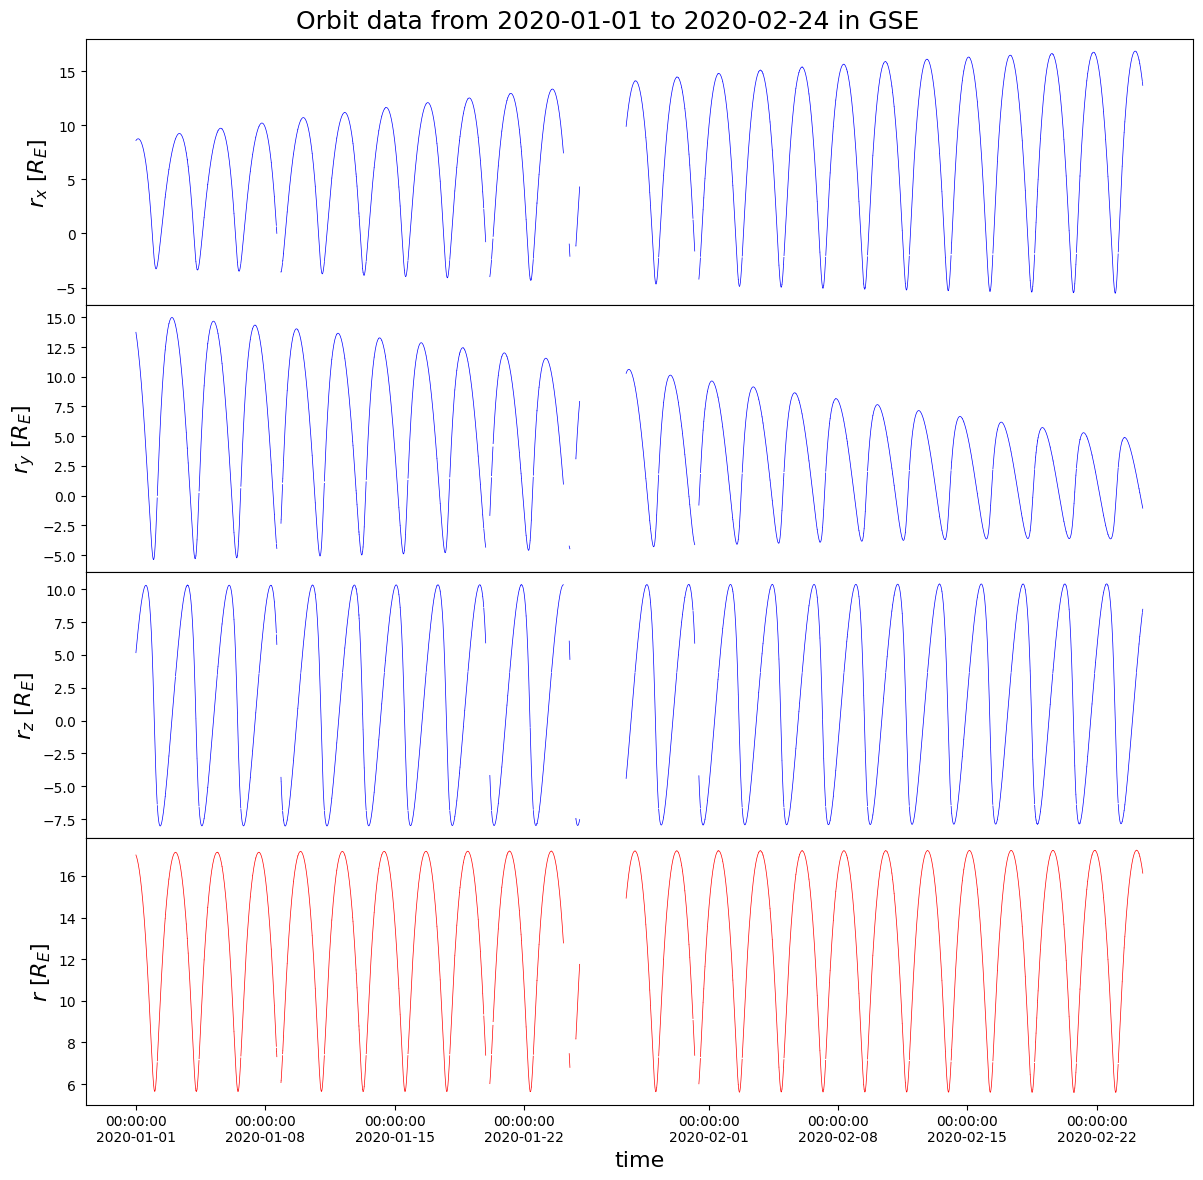

In [120]:
plot_orbit_components(sliced_dataframe, coords='GSE')

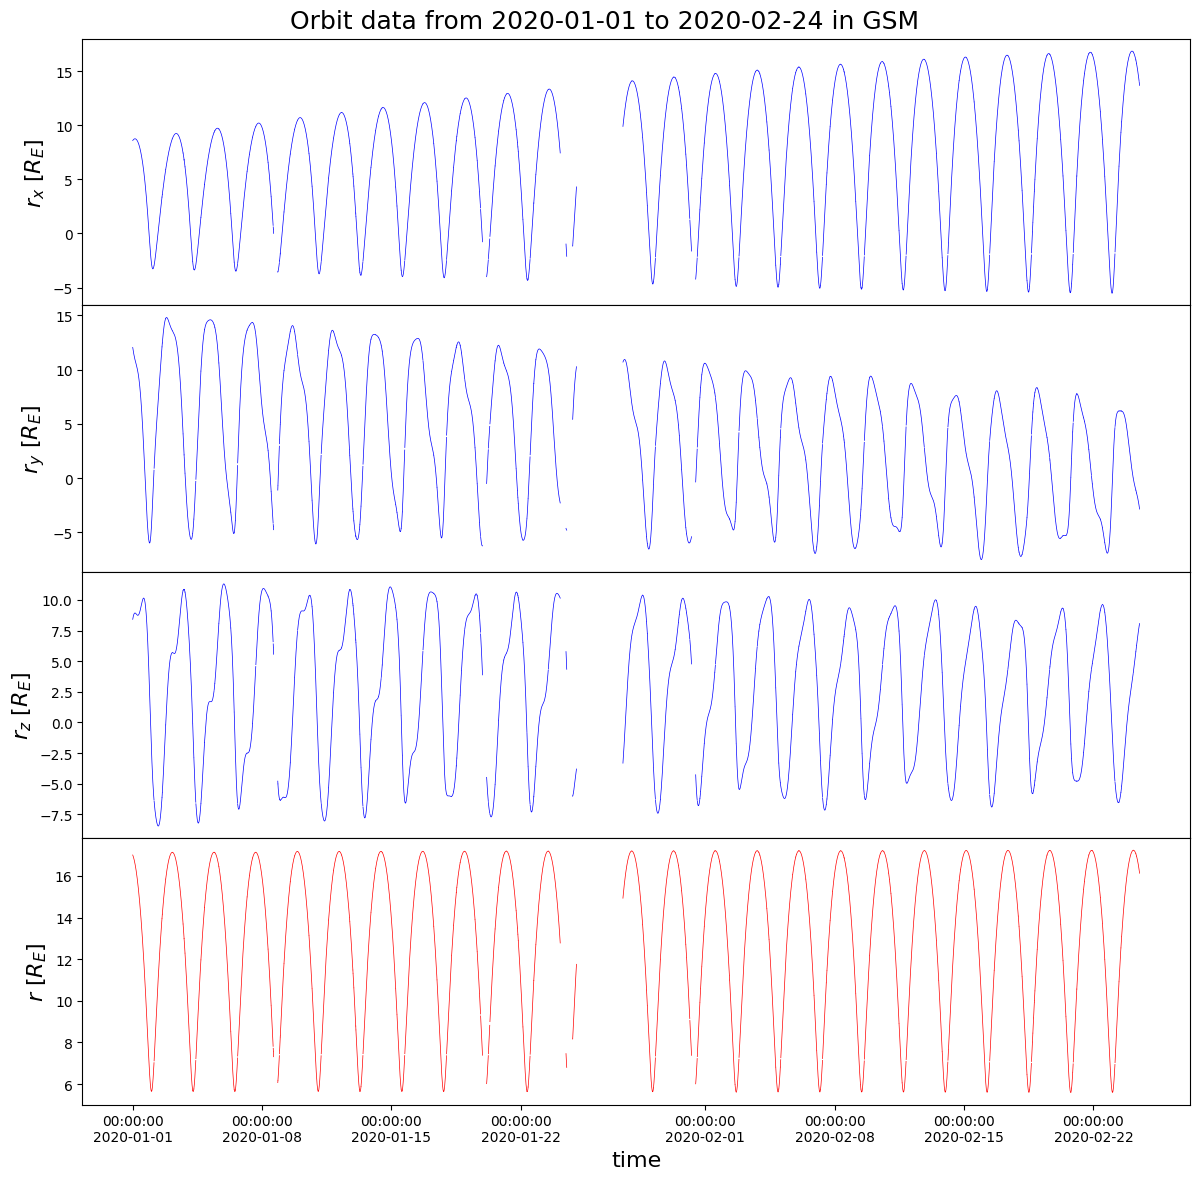

In [121]:
plot_orbit_components(sliced_dataframe, coords='GSM')

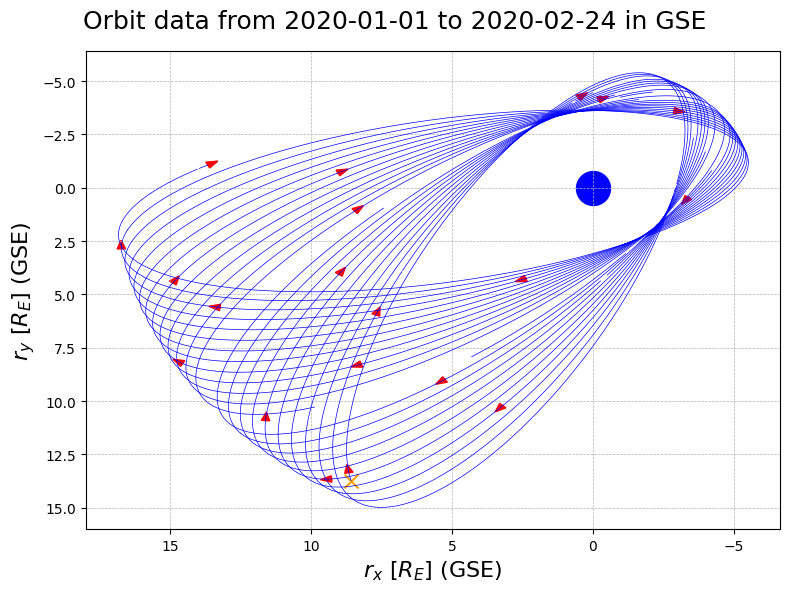

In [122]:
plot_orbit(sliced_dataframe, x_axis='r_x', y_axis='r_y', coords='GSE')

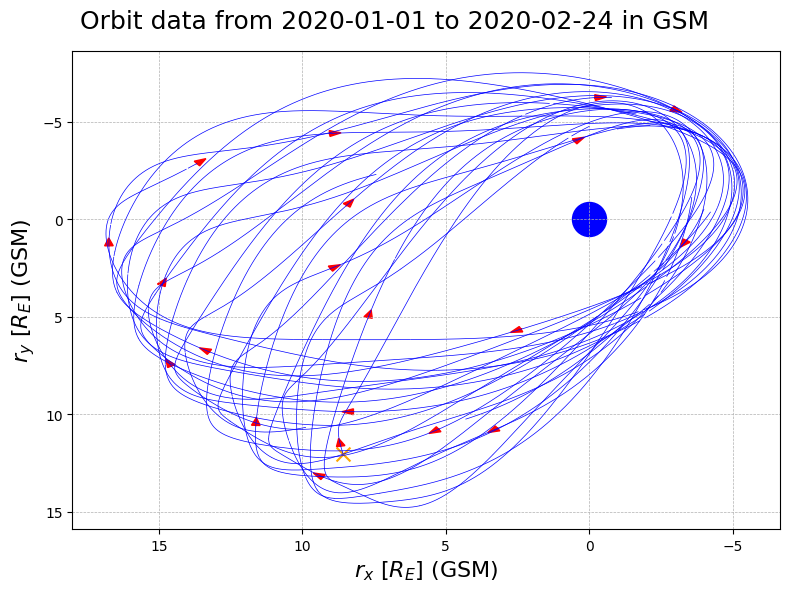

In [123]:
plot_orbit(df_fgm_1_min, x_axis='r_x', y_axis='r_y', coords='GSM')

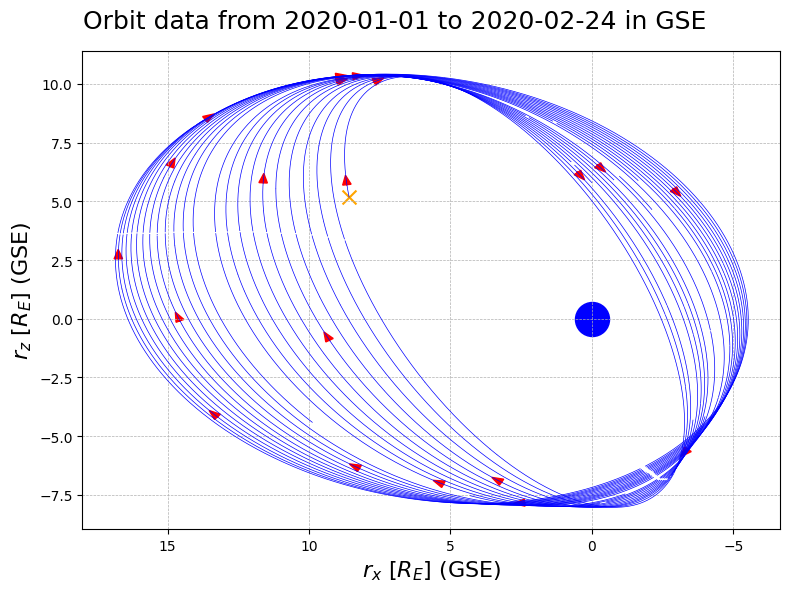

In [124]:
plot_orbit(sliced_dataframe, x_axis='r_x', y_axis='r_z', coords='GSE')

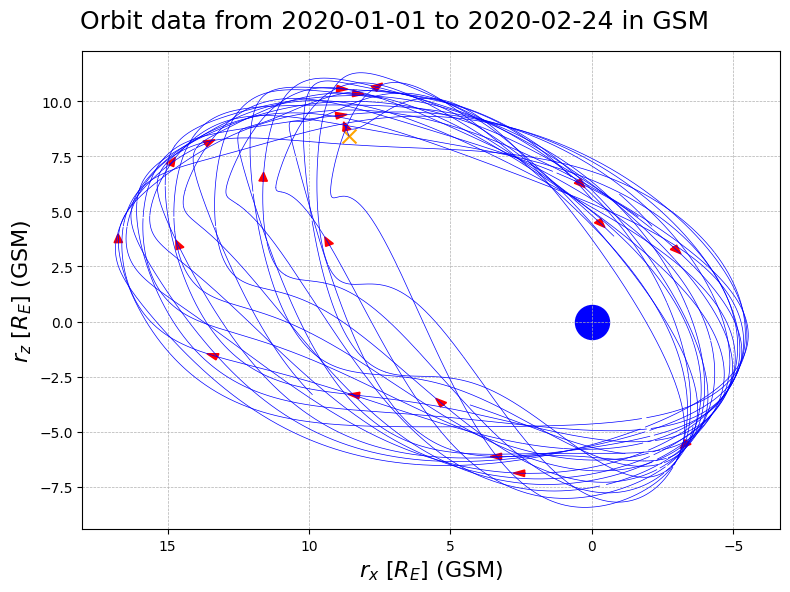

In [125]:
plot_orbit(sliced_dataframe, x_axis='r_x', y_axis='r_z', coords='GSM')

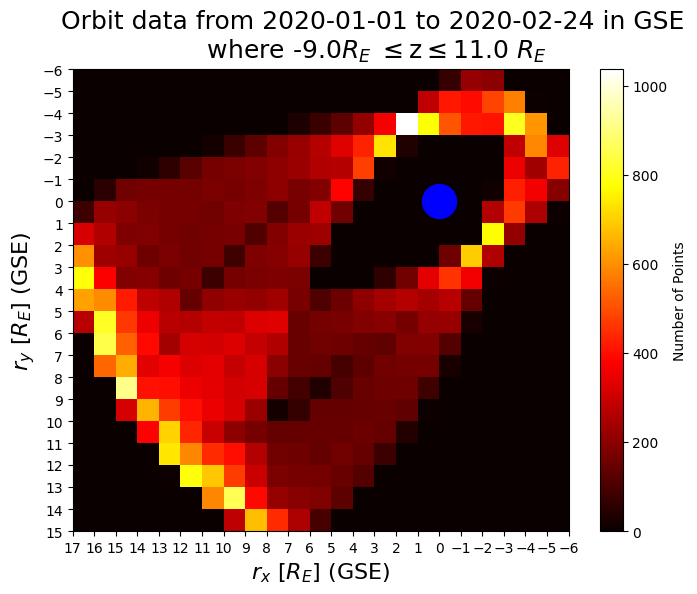

In [126]:
plot_heat_map(sliced_dataframe, x_axis='r_x', y_axis='r_y', coords='GSE', z_limits=None, bin_size=1)

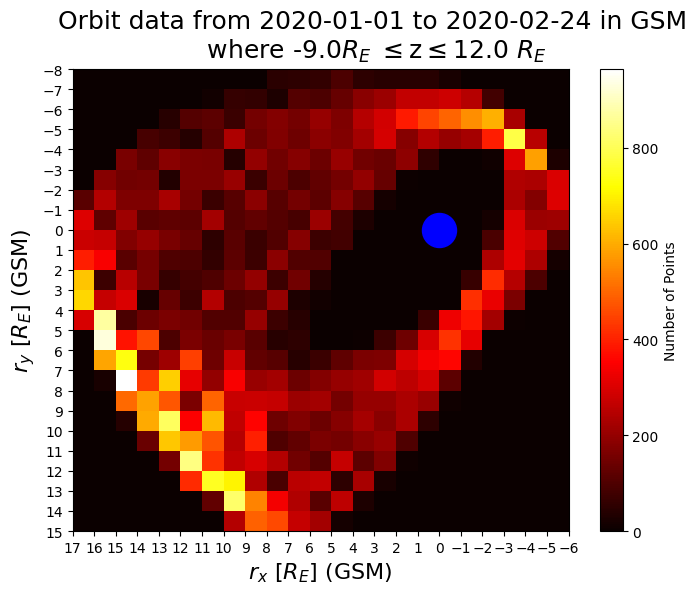

In [127]:
plot_heat_map(sliced_dataframe, x_axis='r_x', y_axis='r_y', coords='GSM', z_limits=None, bin_size=1)